In [1]:
import h5py
import os
import argparse
import glob
import numpy as np
import os 
from tqdm import tqdm
import matplotlib.pyplot as plt
from tabulate import tabulate
import json
import glob
import seaborn as sns

In [26]:
paths = [r"C:\minowa\BloodPressureEstimation\repos\latent-diffusion\logs\2024-11-27T14-34-32_v4_ppg2abp-ldm-kl-4-concat-cv\checkpoints\last.ckpt", 
 r"C:\minowa\BloodPressureEstimation\repos\latent-diffusion\logs\2024-11-27T17-50-06_v4_ppg2abp-ldm-kl-4-concat-cv\checkpoints\last.ckpt", 
 r"C:\minowa\BloodPressureEstimation\repos\latent-diffusion\logs\2024-11-27T21-04-50_v4_ppg2abp-ldm-kl-4-concat-cv\checkpoints\last.ckpt", 
 r"C:\minowa\BloodPressureEstimation\repos\latent-diffusion\logs\2024-11-28T00-18-23_v4_ppg2abp-ldm-kl-4-concat-cv\checkpoints\last.ckpt", 
 r"C:\minowa\BloodPressureEstimation\repos\latent-diffusion\logs\2024-11-28T03-31-30_v4_ppg2abp-ldm-kl-4-concat-cv\checkpoints\last.ckpt", 
 r"C:\minowa\BloodPressureEstimation\repos\latent-diffusion\logs\2024-11-28T06-45-02_v4_ppg2abp-ldm-kl-4-concat-cv\checkpoints\last.ckpt", 
 r"C:\minowa\BloodPressureEstimation\repos\latent-diffusion\logs\2024-11-28T09-58-42_v4_ppg2abp-ldm-kl-4-concat-cv\checkpoints\last.ckpt", 
 r"C:\minowa\BloodPressureEstimation\repos\latent-diffusion\logs\2024-11-28T13-12-21_v4_ppg2abp-ldm-kl-4-concat-cv\checkpoints\last.ckpt", 
 r"C:\minowa\BloodPressureEstimation\repos\latent-diffusion\logs\2024-11-28T16-26-09_v4_ppg2abp-ldm-kl-4-concat-cv\checkpoints\last.ckpt", 
 r"C:\minowa\BloodPressureEstimation\repos\latent-diffusion\logs\2024-11-28T19-42-18_v4_ppg2abp-ldm-kl-4-concat-cv\checkpoints\last.ckpt"]

In [32]:
a = ["//".join(f.split("\\")[:-2])+"//configs//samples" for f in paths]
a 

['C://minowa//BloodPressureEstimation//repos//latent-diffusion//logs//2024-11-27T14-34-32_v4_ppg2abp-ldm-kl-4-concat-cv//configs//samples',
 'C://minowa//BloodPressureEstimation//repos//latent-diffusion//logs//2024-11-27T17-50-06_v4_ppg2abp-ldm-kl-4-concat-cv//configs//samples',
 'C://minowa//BloodPressureEstimation//repos//latent-diffusion//logs//2024-11-27T21-04-50_v4_ppg2abp-ldm-kl-4-concat-cv//configs//samples',
 'C://minowa//BloodPressureEstimation//repos//latent-diffusion//logs//2024-11-28T00-18-23_v4_ppg2abp-ldm-kl-4-concat-cv//configs//samples',
 'C://minowa//BloodPressureEstimation//repos//latent-diffusion//logs//2024-11-28T03-31-30_v4_ppg2abp-ldm-kl-4-concat-cv//configs//samples',
 'C://minowa//BloodPressureEstimation//repos//latent-diffusion//logs//2024-11-28T06-45-02_v4_ppg2abp-ldm-kl-4-concat-cv//configs//samples',
 'C://minowa//BloodPressureEstimation//repos//latent-diffusion//logs//2024-11-28T09-58-42_v4_ppg2abp-ldm-kl-4-concat-cv//configs//samples',
 'C://minowa//BloodP

In [28]:
def calc_min_max(x):
    # x = (x.astype(np.float32)/127.5-1)
    return np.nanmin(x,axis=1),np.nanmax(x,axis=1)

In [33]:
scales = np.load(r"../data\processed\BP_npy\0625_256_2_clean\p00\scale_train.npy")
results = []
for p in a:
    files = glob.glob(p+"\\*\\2024-12-23*\\numpy\\*.npz")
    out = []
    gt = [] 
    result = {}
    print(len(files),files)
    for file in files:
        a = np.load(file)
        _out = a['arr_0'].squeeze()
        _gt = a['arr_1'].squeeze()
        out.append(_out)
        gt.append(_gt)
    out = np.concatenate(out)
    gt = np.concatenate(gt)
    gt[:] -= scales[0,0]
    gt[:] /= scales[0,1]
    out[:] -= scales[0,0]
    out[:] /= scales[0,1]
    result["gt"] = gt
    result["out"] = out
    result["gt_min"],result["gt_max"] = calc_min_max(result["gt"])
    result["out_min"],result["out_max"] = calc_min_max(result["out"])
    result["errors"] = np.zeros((2,*result["out_min"].shape))
    result["errors"][0,:]=result["out_min"]-result["gt_min"]
    result["errors"][1,:]=result["out_max"]-result["gt_max"]
    gt_mean = np.mean(gt.flatten())
    out_mean = np.mean(out.flatten())
    gt_std = np.std(gt.mean(axis=1),dtype=np.float64)
    out_std = np.std(out.mean(axis=1),dtype=np.float64)
    n_samples = result["errors"].shape[1]
    result["me"] = np.mean(result["errors"],axis=1)
    result["mae"] = np.mean(np.abs(result["errors"]),axis=1)
    result["rmse"] = np.sqrt(np.mean(result["errors"]**2,axis=1))
    result["std"] = np.std(result["errors"],axis=1)
    # print(me.shape,mae.shape,rmse.shape,std.shape)
    result["error_5"] = np.count_nonzero(np.abs(result["errors"])<=5,axis=1)/n_samples*100
    result["error_15"] = np.count_nonzero(np.abs(result["errors"])<=15,axis=1)/n_samples*100
    result["error_10"] = np.count_nonzero(np.abs(result["errors"])<=10,axis=1)/n_samples*100
    result["n_samples"] = len(out)
    results.append(result)
    

40 ['C://minowa//BloodPressureEstimation//repos//latent-diffusion//logs//2024-11-27T14-34-32_v4_ppg2abp-ldm-kl-4-concat-cv//configs//samples\\00060880\\2024-12-23-19-47-06\\numpy\\-1-128x1x256-samples.npz', 'C://minowa//BloodPressureEstimation//repos//latent-diffusion//logs//2024-11-27T14-34-32_v4_ppg2abp-ldm-kl-4-concat-cv//configs//samples\\00060880\\2024-12-23-19-47-06\\numpy\\1023-128x1x256-samples.npz', 'C://minowa//BloodPressureEstimation//repos//latent-diffusion//logs//2024-11-27T14-34-32_v4_ppg2abp-ldm-kl-4-concat-cv//configs//samples\\00060880\\2024-12-23-19-47-06\\numpy\\1151-128x1x256-samples.npz', 'C://minowa//BloodPressureEstimation//repos//latent-diffusion//logs//2024-11-27T14-34-32_v4_ppg2abp-ldm-kl-4-concat-cv//configs//samples\\00060880\\2024-12-23-19-47-06\\numpy\\127-128x1x256-samples.npz', 'C://minowa//BloodPressureEstimation//repos//latent-diffusion//logs//2024-11-27T14-34-32_v4_ppg2abp-ldm-kl-4-concat-cv//configs//samples\\00060880\\2024-12-23-19-47-06\\numpy\\127

In [34]:
results

[{'gt': array([[60.810913, 60.859753, 61.250507, ..., 72.77772 , 71.84967 ,
          70.92164 ],
         [66.47683 , 66.6722  , 66.91643 , ..., 70.38435 , 69.94476 ,
          69.50516 ],
         [64.66959 , 64.66959 , 64.91381 , ..., 67.84447 , 67.50255 ,
          67.11179 ],
         ...,
         [62.581528, 62.777092, 63.9505  , ..., 65.51504 , 65.12391 ,
          64.732765],
         [63.559364, 63.559364, 64.146065, ..., 64.732765, 64.34163 ,
          63.9505  ],
         [64.146065, 64.34163 , 65.319466, ..., 65.12391 , 64.732765,
          64.34163 ]], dtype=float32),
  'out': array([[80.00913 , 78.35344 , 79.72894 , ..., 82.04019 , 80.98034 ,
          80.57585 ],
         [79.680374, 77.421196, 78.82307 , ..., 83.89343 , 83.16157 ,
          82.84791 ],
         [80.5425  , 78.14183 , 79.612976, ..., 85.18508 , 84.15319 ,
          84.58012 ],
         ...,
         [79.1649  , 78.083435, 79.51968 , ..., 86.34905 , 85.56477 ,
          84.25325 ],
         [81.00542 , 8

In [35]:
def error_report(result):
  print("""
        test data samples:
        # samples : {}
        
        Eval Stats:   DBP    SBP
        MAE:        {:6.3f} {:6.3f}
        RMSE:       {:6.3f} {:6.3f}
        Mean Error: {:6.3f} {:6.3f}
        STD:        {:6.3f} {:6.3f}
        
        BHS standards range:
        Error   <5mmHg <10mmHg <15mmHg
        gradeA     60%     85%     95%
        gradeB     50%     75%     90%
        gradeC     40%     65%     85%
        DBP     {:5.1f}%  {:5.1f}%  {:5.1f}%
        SBP     {:5.1f}%  {:5.1f}%  {:5.1f}%
          
        
        """.format(
          result["n_samples"],
          *result["mae"],
          *result["rmse"],
          *result["me"],
          *result["std"],
          result["error_5"][0], result["error_10"][0], result["error_15"][0],
          result["error_5"][1], result["error_10"][1], result["error_15"][1],
        ))

In [36]:
all_results = {"mae":[], "rmse":[], "me":[], "std":[], "error_5":[], "error_10":[], "error_15":[]}
for r in results:
    all_results["mae"].append(r["mae"])
    all_results["me"].append(r["me"])
    all_results["rmse"].append(r["rmse"])
    all_results["std"].append(r["std"])
    all_results["error_5"].append(r["error_5"])
    all_results["error_10"].append(r["error_10"])
    all_results["error_15"].append(r["error_15"])


In [37]:
key,value

('error_15',
 [array([57.0713141 , 15.54487179]),
  array([57.51201923, 15.34455128]),
  array([57.97275641, 15.34455128]),
  array([57.63221154, 15.34455128]),
  array([57.59214744, 15.38461538]),
  array([57.41185897, 15.06410256]),
  array([57.47195513, 15.16426282]),
  array([57.53205128, 15.22435897]),
  array([57.99278846, 15.16426282]),
  array([57.31169872, 15.16426282])])

In [38]:
for key, value in all_results.items():
    print(key,value)
    all_results[key] = np.array(value)

mae [array([13.44220813, 34.73453812]), array([13.38536423, 34.76721234]), array([13.37641496, 34.81564272]), array([13.3887768 , 34.78878979]), array([13.39973946, 34.76765221]), array([13.36414059, 34.80482169]), array([13.36829735, 34.83643561]), array([13.35417018, 34.8261399 ]), array([13.36944971, 34.80854138]), array([13.41931434, 34.73401082])]
rmse [array([15.60027722, 39.1388186 ]), array([15.55232837, 39.15486421]), array([15.54590134, 39.20946109]), array([15.57074237, 39.18017716]), array([15.5621761 , 39.16113375]), array([15.53391873, 39.19470628]), array([15.53639887, 39.23086436]), array([15.53228569, 39.21766151]), array([15.53838199, 39.20408158]), array([15.60384954, 39.12734472])]
me [array([ 11.6264902 , -34.49914498]), array([ 11.5632973 , -34.53570345]), array([ 11.52906493, -34.57931038]), array([ 11.56022748, -34.55191194]), array([ 11.55784708, -34.53915762]), array([ 11.52717858, -34.57597521]), array([ 11.51695924, -34.60434724]), array([ 11.52896076, -34.5

In [39]:
all_results["me"]

array([[ 11.6264902 , -34.49914498],
       [ 11.5632973 , -34.53570345],
       [ 11.52906493, -34.57931038],
       [ 11.56022748, -34.55191194],
       [ 11.55784708, -34.53915762],
       [ 11.52717858, -34.57597521],
       [ 11.51695924, -34.60434724],
       [ 11.52896076, -34.596265  ],
       [ 11.52938295, -34.57546341],
       [ 11.61156873, -34.49350581]])

In [40]:
all_results["mae"].shape

(10, 2)

<Axes: >

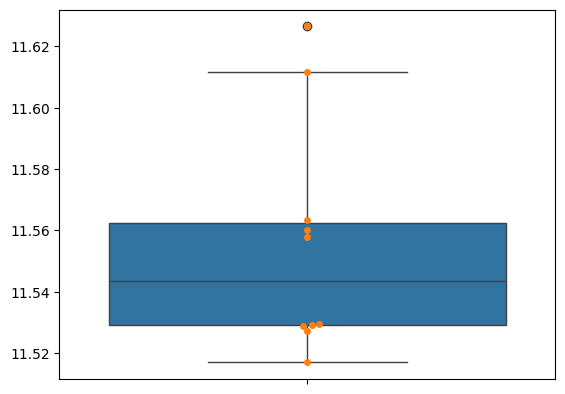

In [41]:
sns.boxplot(all_results["me"][:,0])
sns.swarmplot(all_results["me"][:,0])

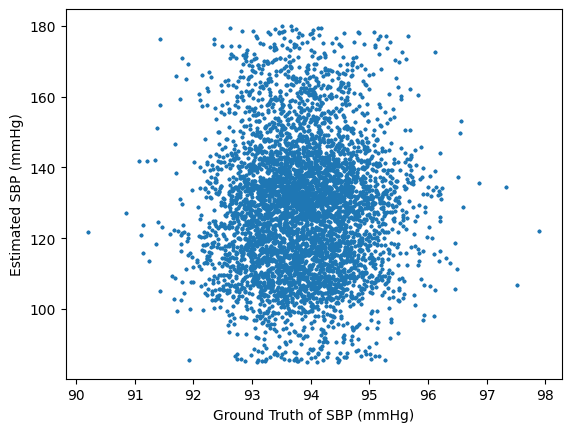

In [42]:
plt.ylabel("Estimated SBP (mmHg)")
plt.xlabel("Ground Truth of SBP (mmHg)")
plt.scatter(results[0]["out_max"],results[0]["gt_max"],s=3)